## MNIST Digit Conversion from 4 to 9 using CycleGAN

* In this Notebook we'll convert digit 4 to digit 9 and vice versa using Cycle GAN Network.
* We'll use MNIST dataset for this project.
* Below is the result that we want to achieve using CycleGANs.

<center>Conversion of 4 to 9</center>

<center>

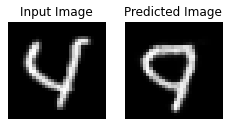


</center>

<center>Conversion of 9 to 4</center>

<center>

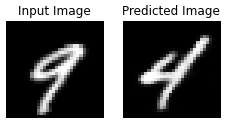

</center>

### Pipeline
The Sequence of the Project

1. Importing Libraries
2. Data Loading and Visualization
3. Data Preprocessing
4. Model Building
5. Model Training
6. Generating a GIF

### Import Libraries

Versions of Libraries -

1.   numpy - 1.19.2
2.   tensorflow - 2.4.1
3.   matplotlib - 3.3.2
4.   skimage - 0.17.2







In [2]:
!pip install matplotlib
!pip install scikit-image
!pip install glob
!pip install keras
!pip install imageio

ERROR: Could not find a version that satisfies the requirement glob
ERROR: No matching distribution found for glob


In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.utils.vis_utils import plot_model
import imageio
import glob

In [4]:
tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 3080, pci bus id: 0000:09:00.0, compute capability: 8.6



### Data Loading and Visualization
1. Data Loading
2. Data Visualization

#### Data Loading

In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [6]:
train_images.shape

(60000, 28, 28)

Declare Batch Size

In [7]:
BATCH_SIZE = 128

#### Data Visualization of Image containing 4 and 9

In [8]:
img4 = train_images[train_labels == 4]
img4 = (img4/127.5)-1.0 # Normalize the images to [-1.0, 1.0]
img4.shape

(5842, 28, 28)

Total 5842 Images of digit 4

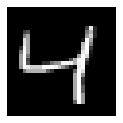

In [9]:
plt.figure(figsize=(2, 2))
plt.imshow(img4[0], cmap='gray')
plt.axis('off')
plt.show()

In [10]:
img9 = train_images[train_labels == 9]
img9 = (img9/127.5)-1.0 # Normalize the images to [-1.0, 1.0]
img9.shape

(5949, 28, 28)

Total 5949 Images of digit 9

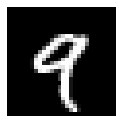

In [11]:
plt.figure(figsize=(2, 2))
plt.imshow(img9[0], cmap='gray')
plt.axis('off')
plt.show()

### Data Preprocessing
1.   Data Resizing
2.   Data Reshaping
3.   Batch and Shuffle Data

#### Resize Images to size (32, 32)

In [12]:
digit4_data = np.zeros((img4.shape[0], 32, 32))
for index, img in enumerate(img4):
    digit4_data[index, :, :] = resize(img, (32, 32))
digit4_data.shape

(5842, 32, 32)

In [13]:
digit9_data = np.zeros((img9.shape[0], 32, 32))
for index, img in enumerate(img9):
    digit9_data[index, :, :] = resize(img, (32, 32))
digit9_data.shape

(5949, 32, 32)

#### Reshape Images to (32, 32, 1) with float pixel values

In [14]:
digit4_data = digit4_data.reshape(digit4_data.shape[0], 32, 32, 1).astype('float32')
digit9_data = digit9_data.reshape(digit9_data.shape[0], 32, 32, 1).astype('float32')

#### Batch and shuffle the data

In [15]:
digit4_data = tf.data.Dataset.from_tensor_slices(digit4_data).shuffle(img4.shape[0], seed=42).batch(BATCH_SIZE)
digit9_data = tf.data.Dataset.from_tensor_slices(digit9_data).shuffle(img9.shape[0], seed=42).batch(BATCH_SIZE)

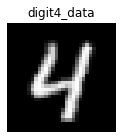

In [16]:
sample_digit4_data = next(iter(digit4_data))
plt.figure(figsize=(2, 2))
plt.imshow(sample_digit4_data[0].numpy()[:, :, 0], cmap='gray')
plt.title('digit4_data')
plt.axis('off')
plt.show()

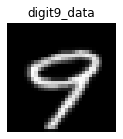

In [17]:
sample_digit9_data = next(iter(digit9_data))
plt.figure(figsize=(2, 2))
plt.imshow(sample_digit9_data[0].numpy()[:, :, 0], cmap='gray')
plt.title('digit9_data')
plt.axis('off')
plt.show()

### Model Building
1. Instance Normalization
2. Downsampling, Upsampling and Unet
3. Generator Building using Unet
4. Discriminator Building

#### Instance Normalization
Instance Normalization are specially used with Style Transfer, where Separate Normalization is performed for each sample we perform channelwise Normalization.

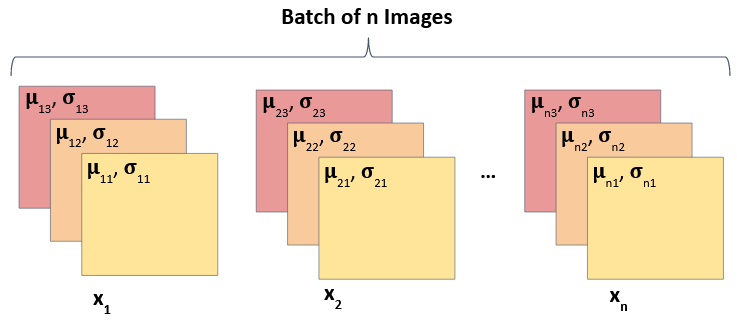

In [18]:
class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        # calling parent's init
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    
    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

#### Downsampling
Downsampling is performed using the Convolution, leading to reduce in dimensions.

In [19]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Conv2d layer
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    # Add Normalization layer
    if apply_norm:
        result.add(InstanceNormalization())
    # Add Leaky Relu Activation
    result.add(tf.keras.layers.LeakyReLU())
    return result

#### Upsampling
Upsampling is a result of Transposed Convolution, where dimension of image are increased.

In [20]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Transposed Conv2d layer
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    # Add Normalization Layer
    result.add(InstanceNormalization())
    # Conditionally add Dropout layer
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    # Add Relu Activation Layer
    result.add(tf.keras.layers.ReLU())
    return result

#### Unets
Unets takes Image as an input and translate it into another Image. <p>
To do this they first use Downsampling on Input Image to learn the latent characteristics of Input Image and then use Upsampling to use this knowledge to Translate it into another Image. <p>
Let's understand it through the below image.

<center>

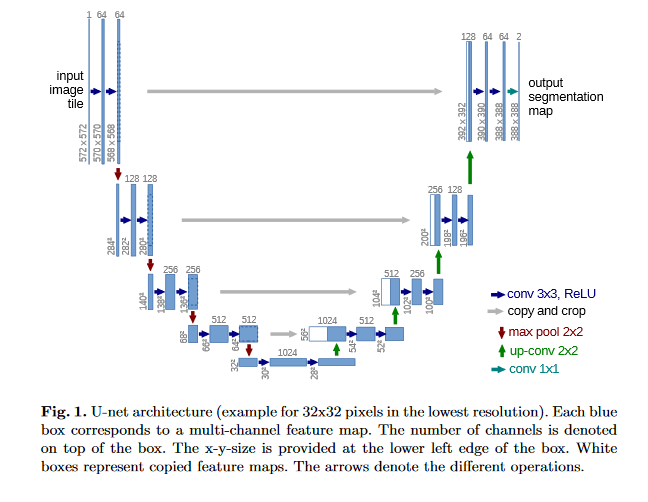

</center>

In [21]:
# Unet Generator is a combination of Convolution + Transposed Convolution Layers
def unet_generator():
    down_stack = [
        downsample(64, 4, False), # (bs, 16, 16, 64)
        downsample(128, 4), # (bs, 8, 8, 128)
        downsample(128, 4), # (bs, 4, 4, 128)
        downsample(128, 4), # (bs, 2, 2, 128)
        downsample(128, 4) # (bs, 1, 1, 128)
    ]
    up_stack = [
        upsample(128, 4, True), # (bs, 2, 2, 256)
        upsample(128, 4, True), # (bs, 4, 4, 256)
        upsample(128, 4), # (bs, 8, 8, 256)
        upsample(64, 4) # (bs, 16, 16, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 32, 32, 1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[32, 32, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

#### Generator
Generator is a Unet Network here since We want to translate One type of Image (digit 4) into Another type of Image (digit 9).

In [22]:
generator_g = unet_generator()
generator_f = unet_generator()

Let's also visualize one of our Generator Models since Both our Generators have same architecture.

Notice How the dimension reduces first but then increases.

In [23]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 16, 16, 64)   1024        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 8, 8, 128)    131328      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4, 4, 128)    262400      sequential_1[0][0]               
______________________________________________________________________________________________

#### Discriminator
Discriminator is a traditional CNN, which we use to classify the Images. It only uses Downsampling hence.

Both Discriminators have same architecture

In [24]:
# Discriminators only contain Convolutional Layers and no Transposed Convolution is not used 
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    # add input layer of size (32, 32, 1)
    inp = tf.keras.layers.Input(shape=[32, 32, 1], name='input_image')
    x = inp
    
    # add downsampling step here
    down1 = downsample(64, 4, False)(x) # (bs, 16, 16, 64)
    down2 = downsample(128, 4)(down1) # (bs, 8, 8, 128)
    # add a padding layer here
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2) # (bs, 10, 10, 128)
    
    # implement a concrete downsampling layer here
    conv = tf.keras.layers.Conv2D(256, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 7, 7, 256)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    
    # apply zero padding layer
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 9, 9, 256)
    
    # add a last pure 2D Convolution layer
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 6, 6, 1)
    return tf.keras.Model(inputs=inp, outputs=last)

In [34]:
discriminator_x = discriminator()
discriminator_y = discriminator()

Have a look at Discriminator's architecture, Notice that The Dimensions are reducing overall at the end since it's a classifier and only Convolution layers are being used.

In [22]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 32, 32, 1)]       0         
_________________________________________________________________
sequential_18 (Sequential)   (None, 16, 16, 64)        1024      
_________________________________________________________________
sequential_19 (Sequential)   (None, 8, 8, 128)         131328    
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 256)         524288    
_________________________________________________________________
instance_normalization_17 (I (None, 7, 7, 256)         512       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 7, 7, 256)         0   

### Model Training
1. Declare Loss type
2. Calculate Discriminator Loss
3. Calculate Generator Loss
4. Cycle Loss
5. Identity Loss
6. Optimizer
7. Checkpoint Initialization
8. Training Flow

Check output of Untrained Generator models which should be a random noise

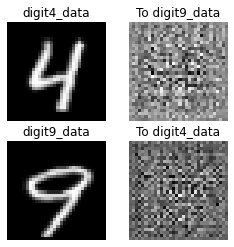

In [25]:
to_digit9_data = generator_g(sample_digit4_data)
to_digit4_data = generator_f(sample_digit9_data)
plt.figure(figsize=(4, 4))

imgs = [sample_digit4_data, to_digit9_data, sample_digit9_data, to_digit4_data]
title = ['digit4_data', 'To digit9_data', 'digit9_data', 'To digit4_data']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0].numpy()[:, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

#### Declare Loss as Binary Cross Entropy
Since Our Discriminator is a classifier

In [26]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Discriminator Loss
It consists of two types of losses
1.    Loss on Real Data
2.    Loss on Fake Data

In [27]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5 # mean of losses

#### Generator Loss
It has only one type of loss - Discriminator Loss on Generated data

In [28]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

#### Cycle Loss
When we use both of Generators sequentially on a Input Image, we get Cycle Image and the L1 Loss between these two is called Cycle Loss.

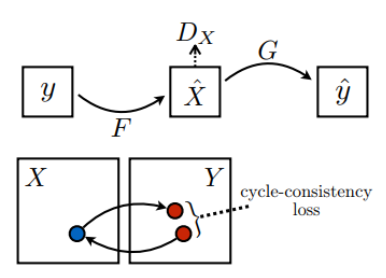

In [29]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss1

#### Identity Loss
When we provide input image to the Generator such that no translation is needed because the Image is already transformed. Here also we take L1 Loss between Input and Output Image.

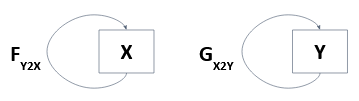

In [30]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5*loss

#### Optimizer 
We use Adam Optimizer to update weights which is a good optimizer to achieve quick learning.

In [31]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

We'll train out Model for 100 Epochs

In [32]:
EPOCHS = 100

#### Checkpoint Initialization
Initialize checkpoints to save models

In [35]:
checkpoint_path = "./Trained_Model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Function to show Images output by Generators while Training

In [37]:
def generate_images(model1, test_input1, model2, test_input2):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(8, 4))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input Image', 'Predicted Image', 'Input Image', 'Predicted Image']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

#### Training FLow
Below Function performs one Flow of Batch Training <p>
Notice that Identity Loss and Cycle Loss are only used in training Generator and not Discriminator

Sequence of Training Flow


1.   Generate Fake Y and Cycled X
2.   Generate Fake X and Cycled Y
3.   Generate Fake Images through G and F for Identity Loss.
4.   Calculate Discriminator Loss for Disc X and Disc Y on Fake Data for Generator Training.
5.   Calculate Generator Loss on Discriminator.
6.   Calculate Cycled Loss on Cycled Images from step 1 and 2.
7.   Calculate Total Generator Loss - Disc Loss + Cycled Loss + Identity Loss
8.   Calculate Discriminator Loss on both Fake and Real Images for Disc X and Y for Disc Training.
9.   Calculate the Gradients and update the weight and bias of models.



In [40]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total generator loss = BCE loss + cycle loss + identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        # Discriminator's loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

#### Train the CycleGAN Model for several Epochs
Loop training function for number of epochs and also show the output at each step. <p>
Note how Generators are getting better at producing realistic images epoch by epoch

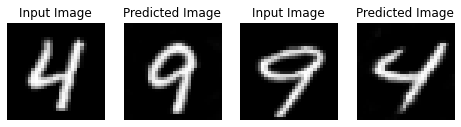

Saving checkpoint for epoch 1 at ./Trained_Model/ckpt-101


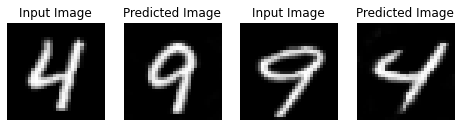

Saving checkpoint for epoch 2 at ./Trained_Model/ckpt-102


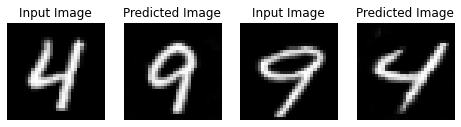

Saving checkpoint for epoch 3 at ./Trained_Model/ckpt-103


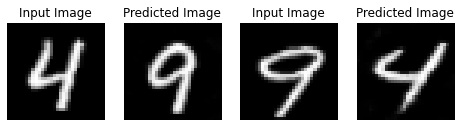

Saving checkpoint for epoch 4 at ./Trained_Model/ckpt-104


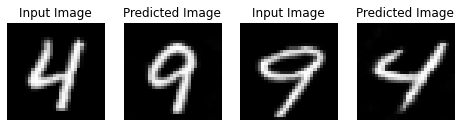

Saving checkpoint for epoch 5 at ./Trained_Model/ckpt-105


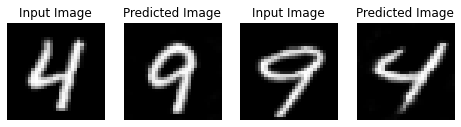

Saving checkpoint for epoch 6 at ./Trained_Model/ckpt-106


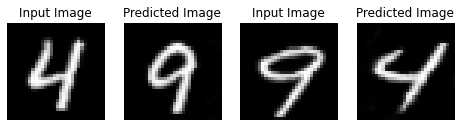

Saving checkpoint for epoch 7 at ./Trained_Model/ckpt-107


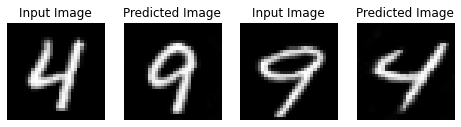

Saving checkpoint for epoch 8 at ./Trained_Model/ckpt-108


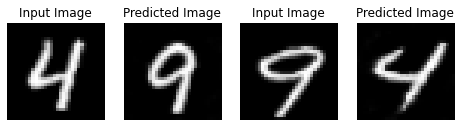

Saving checkpoint for epoch 9 at ./Trained_Model/ckpt-109


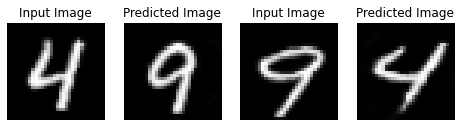

Saving checkpoint for epoch 10 at ./Trained_Model/ckpt-110


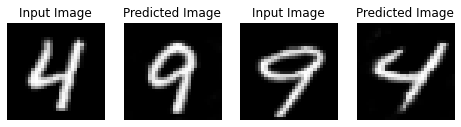

Saving checkpoint for epoch 11 at ./Trained_Model/ckpt-111


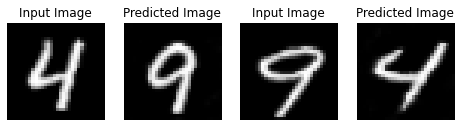

Saving checkpoint for epoch 12 at ./Trained_Model/ckpt-112


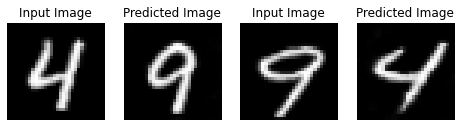

Saving checkpoint for epoch 13 at ./Trained_Model/ckpt-113


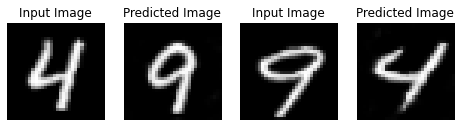

Saving checkpoint for epoch 14 at ./Trained_Model/ckpt-114


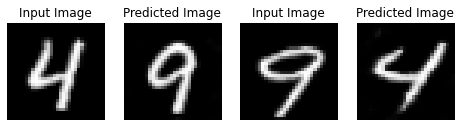

Saving checkpoint for epoch 15 at ./Trained_Model/ckpt-115


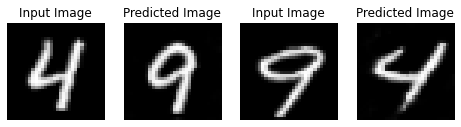

Saving checkpoint for epoch 16 at ./Trained_Model/ckpt-116


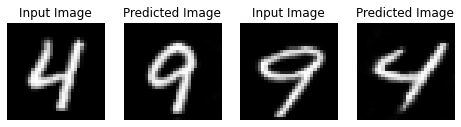

Saving checkpoint for epoch 17 at ./Trained_Model/ckpt-117


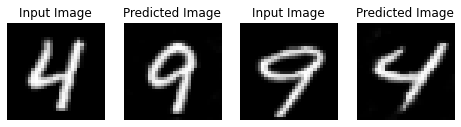

Saving checkpoint for epoch 18 at ./Trained_Model/ckpt-118


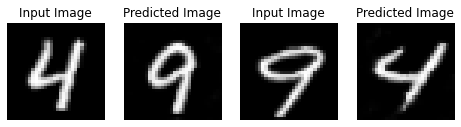

Saving checkpoint for epoch 19 at ./Trained_Model/ckpt-119


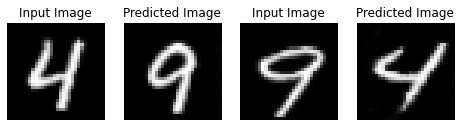

Saving checkpoint for epoch 20 at ./Trained_Model/ckpt-120


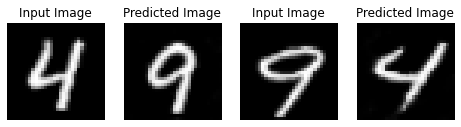

Saving checkpoint for epoch 21 at ./Trained_Model/ckpt-121


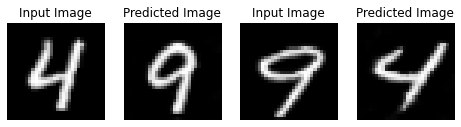

Saving checkpoint for epoch 22 at ./Trained_Model/ckpt-122


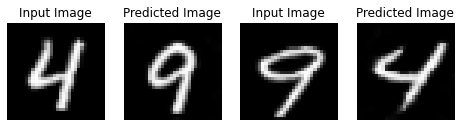

Saving checkpoint for epoch 23 at ./Trained_Model/ckpt-123


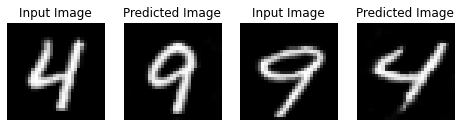

Saving checkpoint for epoch 24 at ./Trained_Model/ckpt-124


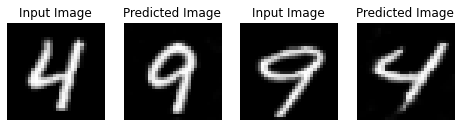

Saving checkpoint for epoch 25 at ./Trained_Model/ckpt-125


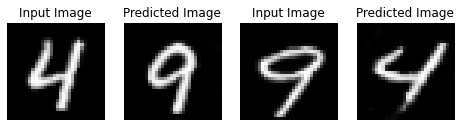

Saving checkpoint for epoch 26 at ./Trained_Model/ckpt-126


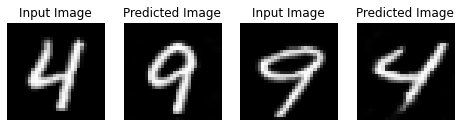

Saving checkpoint for epoch 27 at ./Trained_Model/ckpt-127


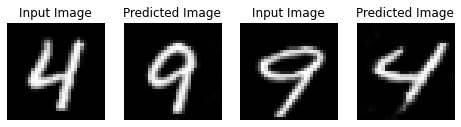

Saving checkpoint for epoch 28 at ./Trained_Model/ckpt-128


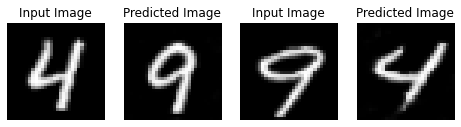

Saving checkpoint for epoch 29 at ./Trained_Model/ckpt-129


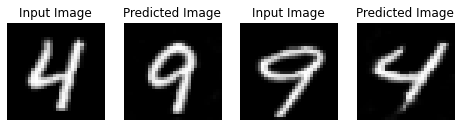

Saving checkpoint for epoch 30 at ./Trained_Model/ckpt-130


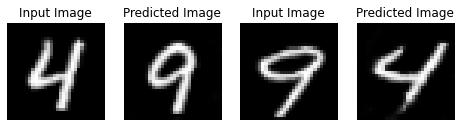

Saving checkpoint for epoch 31 at ./Trained_Model/ckpt-131


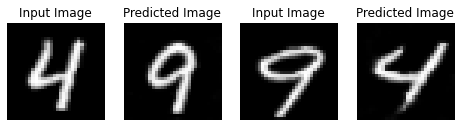

Saving checkpoint for epoch 32 at ./Trained_Model/ckpt-132


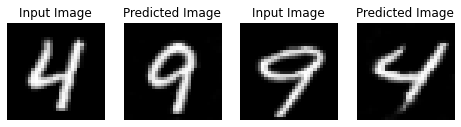

Saving checkpoint for epoch 33 at ./Trained_Model/ckpt-133


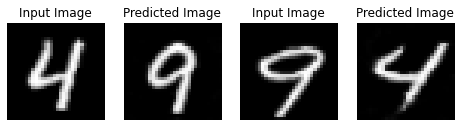

Saving checkpoint for epoch 34 at ./Trained_Model/ckpt-134


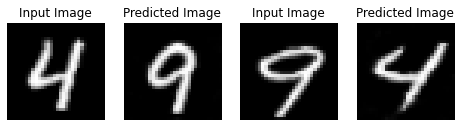

Saving checkpoint for epoch 35 at ./Trained_Model/ckpt-135


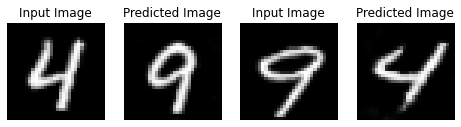

Saving checkpoint for epoch 36 at ./Trained_Model/ckpt-136


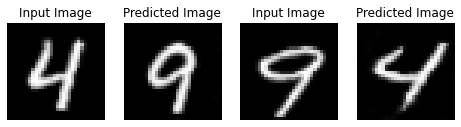

Saving checkpoint for epoch 37 at ./Trained_Model/ckpt-137


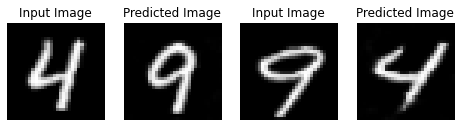

Saving checkpoint for epoch 38 at ./Trained_Model/ckpt-138


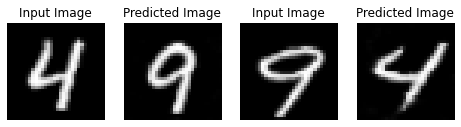

Saving checkpoint for epoch 39 at ./Trained_Model/ckpt-139


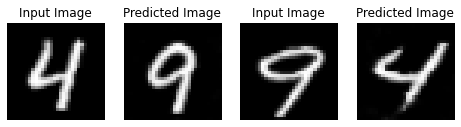

Saving checkpoint for epoch 40 at ./Trained_Model/ckpt-140


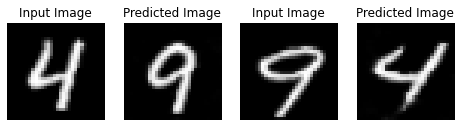

Saving checkpoint for epoch 41 at ./Trained_Model/ckpt-141


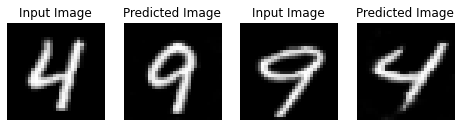

Saving checkpoint for epoch 42 at ./Trained_Model/ckpt-142


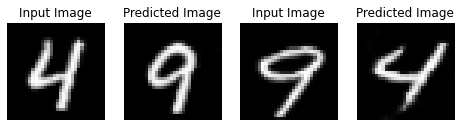

Saving checkpoint for epoch 43 at ./Trained_Model/ckpt-143


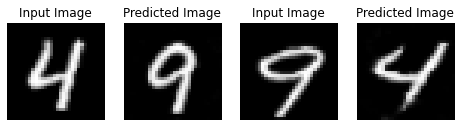

Saving checkpoint for epoch 44 at ./Trained_Model/ckpt-144


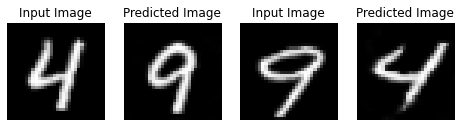

Saving checkpoint for epoch 45 at ./Trained_Model/ckpt-145


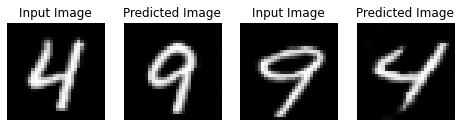

Saving checkpoint for epoch 46 at ./Trained_Model/ckpt-146


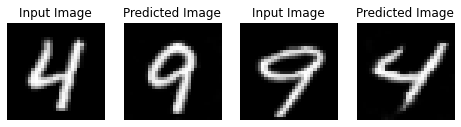

Saving checkpoint for epoch 47 at ./Trained_Model/ckpt-147


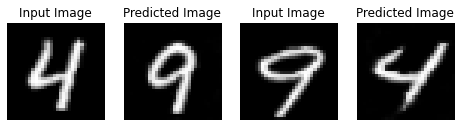

Saving checkpoint for epoch 48 at ./Trained_Model/ckpt-148


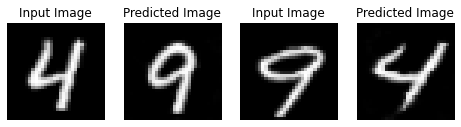

Saving checkpoint for epoch 49 at ./Trained_Model/ckpt-149


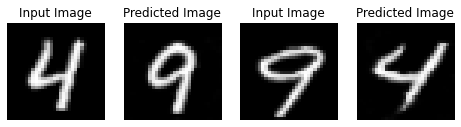

Saving checkpoint for epoch 50 at ./Trained_Model/ckpt-150


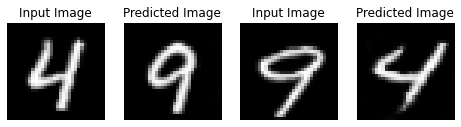

Saving checkpoint for epoch 51 at ./Trained_Model/ckpt-151


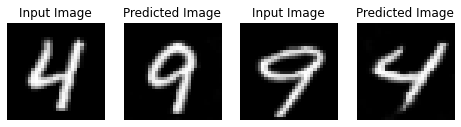

Saving checkpoint for epoch 52 at ./Trained_Model/ckpt-152


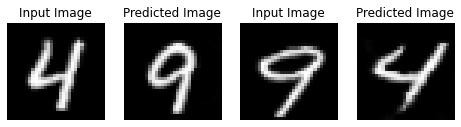

Saving checkpoint for epoch 53 at ./Trained_Model/ckpt-153


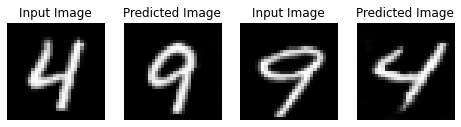

Saving checkpoint for epoch 54 at ./Trained_Model/ckpt-154


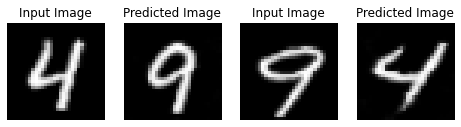

Saving checkpoint for epoch 55 at ./Trained_Model/ckpt-155


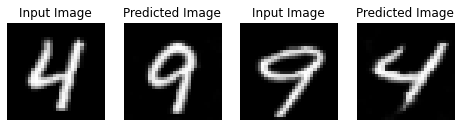

Saving checkpoint for epoch 56 at ./Trained_Model/ckpt-156


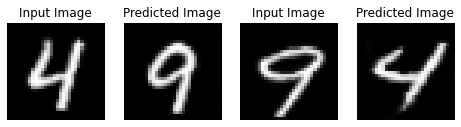

Saving checkpoint for epoch 57 at ./Trained_Model/ckpt-157


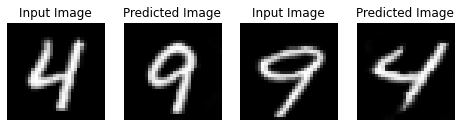

Saving checkpoint for epoch 58 at ./Trained_Model/ckpt-158


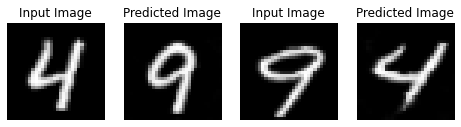

Saving checkpoint for epoch 59 at ./Trained_Model/ckpt-159


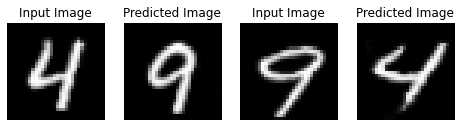

Saving checkpoint for epoch 60 at ./Trained_Model/ckpt-160


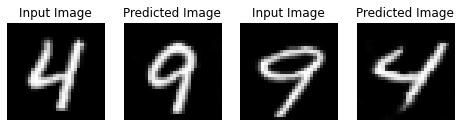

Saving checkpoint for epoch 61 at ./Trained_Model/ckpt-161


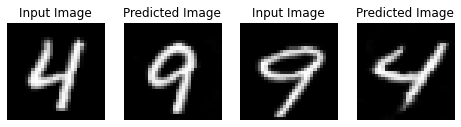

Saving checkpoint for epoch 62 at ./Trained_Model/ckpt-162


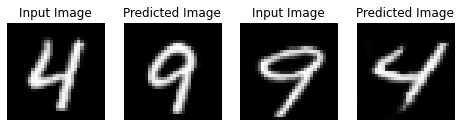

Saving checkpoint for epoch 63 at ./Trained_Model/ckpt-163


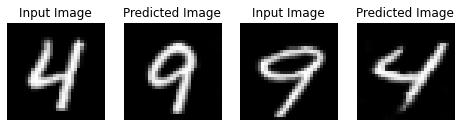

Saving checkpoint for epoch 64 at ./Trained_Model/ckpt-164


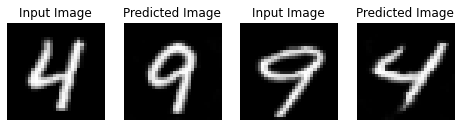

Saving checkpoint for epoch 65 at ./Trained_Model/ckpt-165


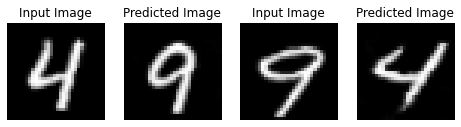

Saving checkpoint for epoch 66 at ./Trained_Model/ckpt-166


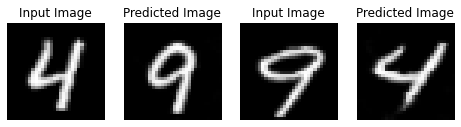

Saving checkpoint for epoch 67 at ./Trained_Model/ckpt-167


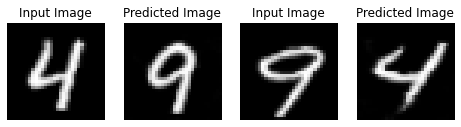

Saving checkpoint for epoch 68 at ./Trained_Model/ckpt-168


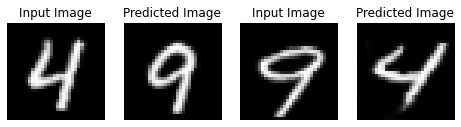

Saving checkpoint for epoch 69 at ./Trained_Model/ckpt-169


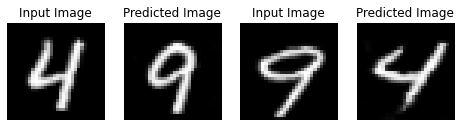

Saving checkpoint for epoch 70 at ./Trained_Model/ckpt-170


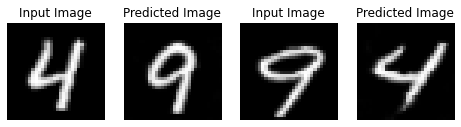

Saving checkpoint for epoch 71 at ./Trained_Model/ckpt-171


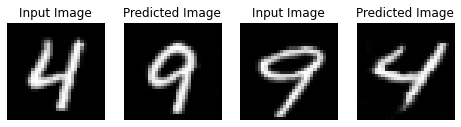

Saving checkpoint for epoch 72 at ./Trained_Model/ckpt-172


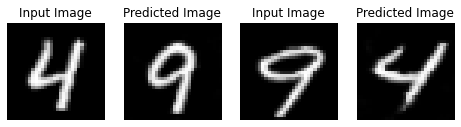

Saving checkpoint for epoch 73 at ./Trained_Model/ckpt-173


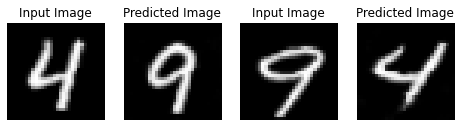

Saving checkpoint for epoch 74 at ./Trained_Model/ckpt-174


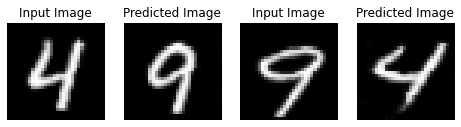

Saving checkpoint for epoch 75 at ./Trained_Model/ckpt-175


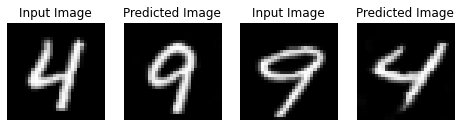

Saving checkpoint for epoch 76 at ./Trained_Model/ckpt-176


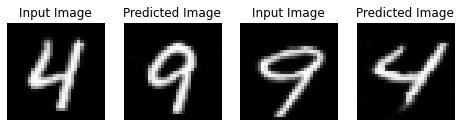

Saving checkpoint for epoch 77 at ./Trained_Model/ckpt-177


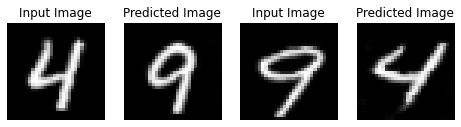

Saving checkpoint for epoch 78 at ./Trained_Model/ckpt-178


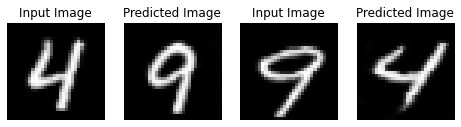

Saving checkpoint for epoch 79 at ./Trained_Model/ckpt-179


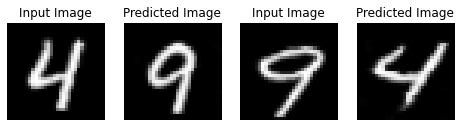

Saving checkpoint for epoch 80 at ./Trained_Model/ckpt-180


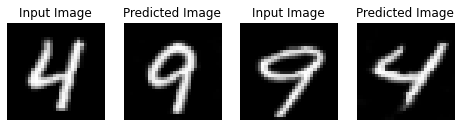

Saving checkpoint for epoch 81 at ./Trained_Model/ckpt-181


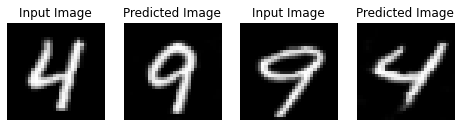

Saving checkpoint for epoch 82 at ./Trained_Model/ckpt-182


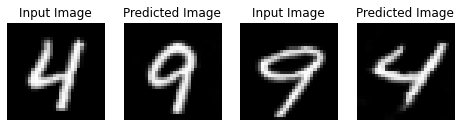

Saving checkpoint for epoch 83 at ./Trained_Model/ckpt-183


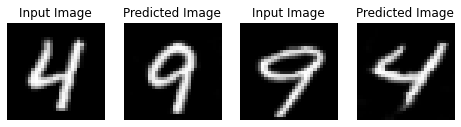

Saving checkpoint for epoch 84 at ./Trained_Model/ckpt-184


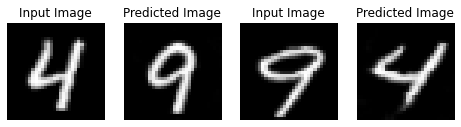

Saving checkpoint for epoch 85 at ./Trained_Model/ckpt-185


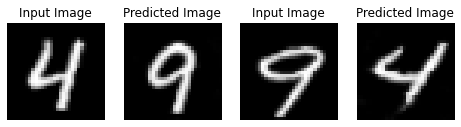

Saving checkpoint for epoch 86 at ./Trained_Model/ckpt-186


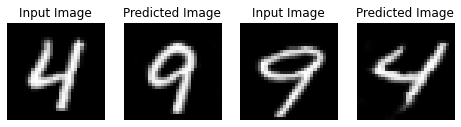

Saving checkpoint for epoch 87 at ./Trained_Model/ckpt-187


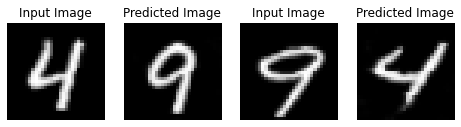

Saving checkpoint for epoch 88 at ./Trained_Model/ckpt-188


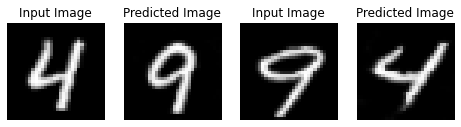

Saving checkpoint for epoch 89 at ./Trained_Model/ckpt-189


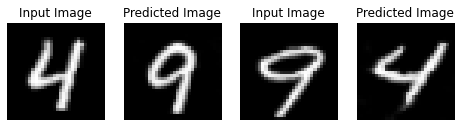

Saving checkpoint for epoch 90 at ./Trained_Model/ckpt-190


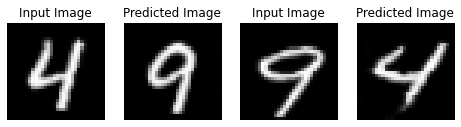

Saving checkpoint for epoch 91 at ./Trained_Model/ckpt-191


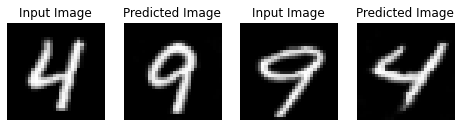

Saving checkpoint for epoch 92 at ./Trained_Model/ckpt-192


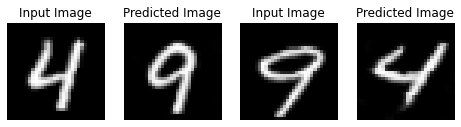

Saving checkpoint for epoch 93 at ./Trained_Model/ckpt-193


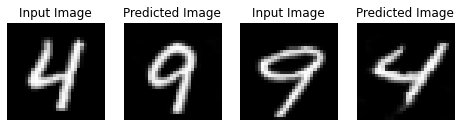

Saving checkpoint for epoch 94 at ./Trained_Model/ckpt-194


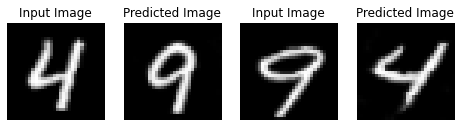

Saving checkpoint for epoch 95 at ./Trained_Model/ckpt-195


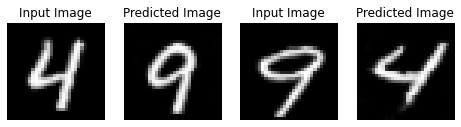

Saving checkpoint for epoch 96 at ./Trained_Model/ckpt-196


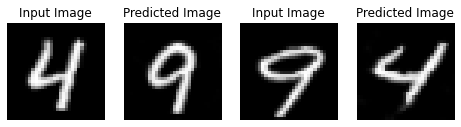

Saving checkpoint for epoch 97 at ./Trained_Model/ckpt-197


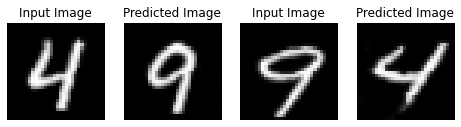

Saving checkpoint for epoch 98 at ./Trained_Model/ckpt-198


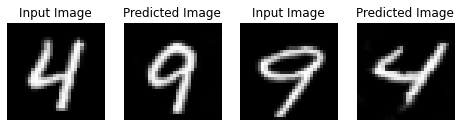

Saving checkpoint for epoch 99 at ./Trained_Model/ckpt-199


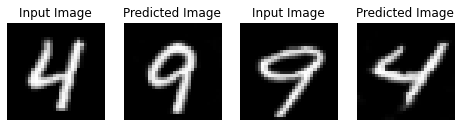

Saving checkpoint for epoch 100 at ./Trained_Model/ckpt-200
CPU times: user 3min 37s, sys: 1min 24s, total: 5min 2s
Wall time: 4min 34s


In [42]:
%%time
for epoch in range(1, EPOCHS+1):
    for image_x, image_y in tf.data.Dataset.zip((digit4_data, digit9_data)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_digit4_data, generator_f, sample_digit9_data)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

### Generating a GIF for visualization of Results
Notice the Quality of results we are getting.

In [43]:
anim_file = 'cyclegan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [44]:
pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-v033zlvt
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-v033zlvt
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0b3522779b8846b24561783883d5a15a71b5c3f19_-py3-none-any.whl size=144068 sha256=1c666464634d9d9ba4593183873c04e7c28ee658f1a8bf389f560073ab47ca05
  Stored in directory: /tmp/pip-ephem-wheel-cache-8jh8wywj/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Failed to build tensorflow-docs
    Running setup.py install for tensorflow-docs ... done
  DEPRECATION: tensorflow-docs was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
Note: you may need to restart the kernel to use updated packages.



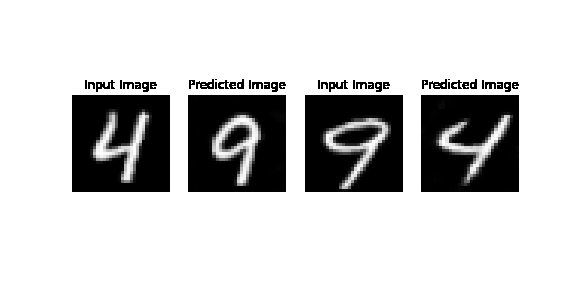

In [45]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)